In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 384 (delta 124), reused 101 (delta 67), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=c635258cc4918841441cceff34824800f6a3a681c8fc0a387117536fba1fbe5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_igipcn/wheels/55/59/29/0fb1c635652

In [2]:
from dul_2021.utils.hw12_utils import *

In [3]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import tqdm, trange
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [4]:
# net architecture taken from practice 12
class Net(nn.Module):
    def __init__(self, n=10, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)
        self.last = nn.Linear(out_dim, n)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.reshape(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return self.last(features)

In [5]:
class VAT(nn.Module): 
    def __init__(self, n, alpha, xi):
        super().__init__()
        self.model = Net(n)
        self.alpha = alpha
        self.xi = xi

    def calc_loss(self, b, labels):
        b = b.to(device)
        labels = labels.to(device)

        # labeled loss part + here we can calculate accuracy score
        with_label = (labels != -1)
        preds = self.model(b[with_label])
        labeled_loss = F.cross_entropy(preds, labels[with_label], reduction="none")
        accuracy = (torch.argmax(preds, dim=1) == labels[with_label]).sum()

        # unlabeled loss part
        with torch.no_grad():
            pred = F.log_softmax(self.model(b), dim=1)
        r = self.xi * F.normalize(torch.randn(b.shape).to(device), dim=(1,2,3)).requires_grad_()
        p = F.log_softmax(self.model(b + r), dim=1)
        distrib = F.kl_div(p, pred, reduction="batchmean")
        r_a = F.normalize(torch.autograd.grad(distrib, r)[0], dim=(1, 2, 3))
        self.model.zero_grad()
        p = F.log_softmax(self.model(b + r_a), dim=1)
        unlabeled_loss = F.kl_div(p, pred, reduction="batchmean")

        return self.alpha * unlabeled_loss.mean() + labeled_loss.mean(), accuracy

    def fit(self, data, epochs, lr):
        opt = Adam(self.parameters(), lr=lr)
        tr_loss, tr_acc = [], []
        for _ in trange(epochs):
            tot, tot_acc = 0, 0
            for b, y in tqdm(data):
                loss, acc = self.calc_loss(b.to(device), y.to(device))
                opt.zero_grad()
                loss.backward()
                opt.step()
                tot_acc += acc
                tot += (y != -1).sum().item()
                tr_loss.append(loss.item())
            tr_acc.append(tot_acc.item() / tot)
        return np.array(tr_loss), np.array(tr_acc)

In [8]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    n = 10
    ne = 10
    lr = 5e-4
    bs = 128
    xi = 10
    alpha = 1

    model = VAT(n=n, alpha=alpha, xi=xi).to(device)
    train_data = DataLoader(train_data, batch_size=bs, shuffle=True)
    loss, acc = model.fit(train_data, epochs=ne, lr=lr)
    return loss, acc

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

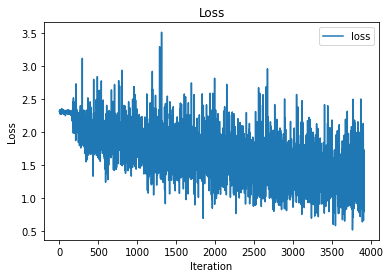

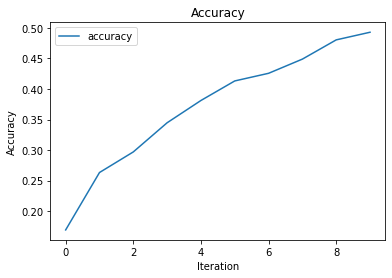

In [9]:
q12_results(q1) # q12_result !

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [14]:
class MixMatch(nn.Module): 
    def __init__(self, n, tau, lam_u):
        super().__init__()
        self.model = Net(n)
        self.lam_u = lam_u
        self.tau = tau
        self.weak_trans = transforms.RandomHorizontalFlip()
        self.strong_trans = transforms.Compose([transforms.RandomGrayscale(0.2),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
                                                transforms.GaussianBlur(kernel_size=5)])

    def calc_loss(self, b, labels):
        b = b.to(device)
        labels = labels.to(device)

        # labeled loss part + here we can calculate accuracy score
        with_label = (labels != -1)
        weak_preds = self.model(self.weak_trans(b[with_label]))
        labeled_loss = F.cross_entropy(weak_preds, labels[with_label], reduction="none")
        accuracy = (torch.argmax(weak_preds, dim=1) == labels[with_label]).sum()

        # unlabeled loss part
        no_label = (labels == -1)
        strong_preds = self.model(self.strong_trans(b[no_label]))
        value, pseudo = torch.max(strong_preds, dim=1)
        thresh = value > self.tau
        unlabeled_loss = F.cross_entropy(strong_preds[thresh], pseudo[thresh], reduction="none")

        return labeled_loss.mean() + self.lam_u * unlabeled_loss.mean(), accuracy

    def fit(self, data, epochs, lr):
        opt = Adam(self.parameters(), lr=lr)
        tr_loss, tr_acc = [], []
        for _ in trange(epochs):
            tot, tot_acc = 0, 0
            for b, y in tqdm(data):
                loss, acc = self.calc_loss(b.to(device), y.to(device))
                opt.zero_grad()
                loss.backward()
                opt.step()
                tot_acc += acc
                tot += (y != -1).sum().item()
                tr_loss.append(loss.item())
            tr_acc.append(tot_acc.item() / tot)
        return np.array(tr_loss), np.array(tr_acc)

In [15]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    n = 10
    ne = 10
    lr = 5e-4
    bs = 128
    tau = 0.7
    lam_u = 10

    model = MixMatch(n=n, tau=tau, lam_u=lam_u).to(device)
    train_data = DataLoader(train_data, batch_size=bs, shuffle=True)
    loss, acc = model.fit(train_data, epochs=ne, lr=lr)
    return loss, acc

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

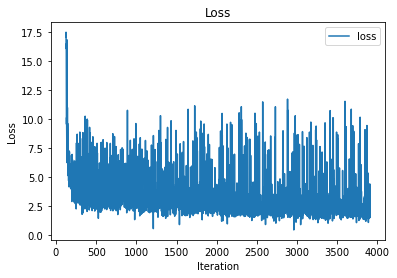

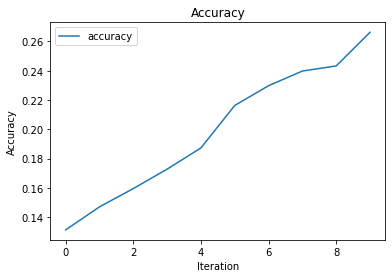

In [16]:
q12_results(q2) # q12_results!

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """